# PupilAnalysis_Pain - Data Processing
    
#### This algorithm is for:
- Perform signal processing and preprocessing
    - Remove empty cells (outliers)
    - Calculate signal loss
    - Rebuild signal loss intervals (data missing)
    - Smooth the signal

#### Important considerations before exporting Tobii database to Python
- The Tobii Tx300 equipment has an acquisition rate of 300Hz
- Tobii Studio exports up to 86 variables
- Long experiments or with many volunteers can generate very large databases
     - For example, a 5 minute experiment performed with 50 participants will generate a matrix with 4,500,000 lines (5 minutes X 60 seconds X 50 participants X 300Hz = 4,500,000)
     - In this example, when exporting all possible variables, a matrix of [4500000x86] will be obtained and this will generate some unnecessary difficulties when loading the database in other programs. So to optimize the process, avoid exporting variables that you will not use.
- Essentially necessary variables for this script:
    - ParticipantName
    - MediaName
    - PupilLeft
    - PupilRight

### Step 0: Load Necessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.signal import savgol_filter
from tqdm import tqdm
import time

### Step 1: Load the dataset

In [2]:
# Enter the path where the exported database was stored
# Put the letter r before the path to avoid misinterpretation of the backslash \
df = pd.read_csv(r"C:\Users\rafae\Desktop\DOC\EscalasDor_Data_Export.tsv", sep="\t") # Read file
# A "DtypeWarning" alert message will probably appear because there is more than one data type in the same column,
# this issue will be addressed in steps 3 and 4.

C:\Users\rafae\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Step 2: View loaded data properties

In [3]:
# Check in which pupil there was the greatest signal loss
print("Amostras da pupila esquerda:",df.PupilLeft.count()) # Print number of valid Samples (without NaN) from the Left Pupil
print("Amostras da pupila direita:",df.PupilRight.count()) # Print number of valid Samples (without NaN) from the Right Pupil

Amostras da pupila esquerda: 13627438
Amostras da pupila direita: 13664868


In [4]:
print("Estímulos:",np.unique(df[df["MediaName"].notna()].MediaName)) # Filter NaN and print name of all stimuli

Estímulos: ['03_111418.bmp' '05_105754_110248.bmp' '05_110222.bmp'
 '06_112348_145026.bmp' '06_112553.bmp' '07_114829.bmp' '07_114907.bmp'
 '08_150034_150434.bmp' '08_150212.bmp' '09_141714.bmp'
 '09_142318_142459.bmp' '15_151515.bmp' '15_151810.bmp' '19_114838.bmp'
 '19_114922.bmp' '20_122223.bmp' '20_122527.bmp' '21_124220.bmp'
 '24_150608.bmp' '24_150657_150701.bmp' '25_103048.bmp' '25_103203.bmp'
 'cross.jpg']


In [5]:
print("Participantes:",np.unique(df.ParticipantName)) # Prints the identification of all subjects

Participantes: ['P10' 'P100' 'P101' 'P102' 'P103' 'P104' 'P105' 'P106' 'P107' 'P108'
 'P109' 'P11' 'P110' 'P111' 'P112' 'P113' 'P114' 'P115' 'P116' 'P117'
 'P118' 'P119' 'P12' 'P120' 'P121' 'P122' 'P123' 'P124' 'P125' 'P126'
 'P127' 'P128' 'P129' 'P13' 'P130' 'P131' 'P132' 'P133' 'P134' 'P135'
 'P136' 'P137' 'P138' 'P139' 'P14' 'P140' 'P141' 'P142' 'P143' 'P144'
 'P145' 'P146' 'P147' 'P148' 'P149' 'P15' 'P150' 'P151' 'P152' 'P153'
 'P154' 'P155' 'P156' 'P157' 'P158' 'P159' 'P16' 'P160' 'P161' 'P162'
 'P163' 'P164' 'P165' 'P166' 'P17' 'P18' 'P19' 'P20' 'P21' 'P22' 'P23'
 'P24' 'P25' 'P26' 'P27' 'P28' 'P29' 'P30' 'P31' 'P32' 'P33' 'P34' 'P35'
 'P36' 'P37' 'P38' 'P39' 'P40' 'P41' 'P42' 'P43' 'P44' 'P45' 'P46' 'P47'
 'P48' 'P49' 'P50' 'P51' 'P52' 'P53' 'P54' 'P55' 'P56' 'P57' 'P58' 'P59'
 'P60' 'P61' 'P62' 'P63' 'P64' 'P65' 'P66' 'P67' 'P68' 'P69' 'P70' 'P71'
 'P72' 'P73' 'P74' 'P75' 'P76' 'P77' 'P78' 'P79' 'P80' 'P81' 'P82' 'P83'
 'P84' 'P85' 'P86' 'P87' 'P88' 'P89' 'P90' 'P91' 'P92' 'P93

In [6]:
# Check if it is necessary to exclude or convert the type of some variable
print(df.info()) # Print summary of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15270651 entries, 0 to 15270650
Data columns (total 13 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   ParticipantName            object 
 1   RecordingName              object 
 2   MediaName                  object 
 3   LocalTimeStamp             object 
 4   FixationIndex              float64
 5   GazeEventDuration          float64
 6   FixationPointX (MCSpx)     float64
 7   FixationPointY (MCSpx)     float64
 8   SaccadicAmplitude          object 
 9   AbsoluteSaccadicDirection  object 
 10  PupilLeft                  object 
 11  PupilRight                 object 
 12  Unnamed: 12                float64
dtypes: float64(5), object(8)
memory usage: 1.5+ GB
None


### Step 3: Organize and clean the dataset
- In this step, instead of excluding the data that you are not going to use, select only the data that you are going to use and overwrite the database

In [7]:
# Select only the columns you are going to user
df = df[['ParticipantName','MediaName','PupilRight']]
# Rename the Pupil with the most recorded samples to "Pupil"
df.rename(columns = {'PupilRight':'Pupil'}, inplace = True)
display(df)

,ParticipantName,MediaName,Pupil
0,P10,NaN,"4,48"
1,P10,NaN,"4,51"
2,P10,NaN,"4,52"
3,P10,NaN,"4,51"
4,P10,NaN,"4,50"
...,...,...,...
15270646,P166,NaN,NaN
15270647,P166,NaN,NaN
15270648,P166,NaN,NaN
15270649,P166,NaN,NaN


In [8]:
# List the subjects to be used (Name of the Participant associated with the Tobii Studio recording)
# P 1:44 = experts # 44
# P 45:73 = parents # 29
# P 73:102 = non_parents # 29

experts = ['P15','P33','P26','P27','P28','P31','P30','P38','P36','P75',
          'P66','P46','P48','P47','P85','P90','P83','P89','P84','P93',
          'P94','P100','P99','P103','P146','P143','P142','P141','P134','P133',
          'P124','P123','P166','P165','P164','P162','P163','P151','P148','P149',
          'P152','P153','P157','P160']
parents = ['P53','P52','P51','P49','P42','P40','P41','P35','P34','P20',
           'P86','P81','P76','P77','P87','P104','P102','P107','P120','P121',
           'P122','P114','P117','P125','P126','P155','P154','P159','P158']
# P62 removed
non_experts = ['P70','P60','P59','P58','P64','P65','P56','P57','P67',
               'P68','P45','P44','P43','P61','P16','P37','P50','P78','P88',
               'P79','P101','P105','P106','P108','P113','P118','P119','P116','P161']
p = experts + parents + non_experts

df = df[df.ParticipantName.isin(p)] # Select only participants from the list and overwrite the dataset
display(df)

,ParticipantName,MediaName,Pupil
560836,P15,NaN,NaN
560837,P15,NaN,NaN
560838,P15,NaN,NaN
560839,P15,NaN,NaN
560840,P15,NaN,NaN
...,...,...,...
15270646,P166,NaN,NaN
15270647,P166,NaN,NaN
15270648,P166,NaN,NaN
15270649,P166,NaN,NaN


In [9]:
# List the MediaName to be used (Name of the media/stimuli element from the Tobii Studio test timeline)
com_dor = ["05_105754_110248.bmp","06_112553.bmp","07_114907.bmp","08_150212.bmp","09_142318_142459.bmp",
           "15_151810.bmp","19_114922.bmp","20_122527.bmp","24_150657_150701.bmp","25_103203.bmp"] 
sem_dor = ["05_110222.bmp","06_112348_145026.bmp","07_114829.bmp", "08_150034_150434.bmp","09_141714.bmp",
           "15_151515.bmp","19_114838.bmp","20_122223.bmp","24_150608.bmp","25_103048.bmp"]
stimuli = com_dor + sem_dor # Concatenate lists

df = df[df.MediaName.isin(stimuli)] # Select only stimuli from the list and overwrite the dataset
display(df)

,ParticipantName,MediaName,Pupil
575864,P15,19_114922.bmp,"3,37"
575865,P15,19_114922.bmp,"3,27"
575866,P15,19_114922.bmp,"3,29"
575867,P15,19_114922.bmp,"3,35"
575868,P15,19_114922.bmp,"3,36"
...,...,...,...
15268840,P166,20_122527.bmp,"3,14"
15268841,P166,20_122527.bmp,"3,14"
15268842,P166,20_122527.bmp,"3,17"
15268843,P166,20_122527.bmp,"3,13"


### Step 4: Fix data type and format

In [10]:
df["Pupil"] = df["Pupil"].replace(",",".", regex=True) # Replace comma with dot, use regex parameter to apply to df 
df["Pupil"] = pd.to_numeric(df["Pupil"]) # Convert data type to numeric (Float)
display(df)

,ParticipantName,MediaName,Pupil
575864,P15,19_114922.bmp,3.37
575865,P15,19_114922.bmp,3.27
575866,P15,19_114922.bmp,3.29
575867,P15,19_114922.bmp,3.35
575868,P15,19_114922.bmp,3.36
...,...,...,...
15268840,P166,20_122527.bmp,3.14
15268841,P166,20_122527.bmp,3.14
15268842,P166,20_122527.bmp,3.17
15268843,P166,20_122527.bmp,3.13


### Step 5: Analyze signal loss by participant
- Commonly, the criterion of 70% of valid samples is used
    - Check if the signal acquisition rate is equal to or higher than the stipulated criterion
    - Remove participants with acquisition rate below the criteria

In [11]:
lista1 = []; lista2 = []; lista3 = []  # Declare lists to store the amount of samples
# Loop repeat to list all participants
for i in p:
    dfi = df["ParticipantName"]==i # Filter the participant
    lista1.append(len(df[dfi])) # Filter all samples of the participant
    lista2.append(len(df[dfi][df[dfi]["Pupil"].notna()])) # Filter only samples recorded, without NaN
    lista3.append(len(df[dfi][df[dfi]["Pupil"].notna()])/len(df[dfi])) # Calculate rec rate
report = pd.DataFrame(data={'AllSamples':lista1,'ValidSamples':lista2,'RecRate':lista3}, index=[p]) # Create Report
display(report) 

,AllSamples,ValidSamples,RecRate
P15,42095,41925,0.995962
P33,42099,39423,0.936436
P26,42096,38978,0.925931
P27,42098,40898,0.971495
P28,42094,39819,0.945954
...,...,...,...
P113,42097,36609,0.869634
P118,42095,38045,0.903789
P119,42098,41300,0.981044
P116,42096,31371,0.745225


In [12]:
# Check if there is any participant with acquisition rate below the criteria
criterio = 0.7 # Define criteria (normally 70% is used)
dfc = report['RecRate'] < criterio 
display(report[dfc])
# If you need to remove a participant, edit the 2nd part of step 3

,AllSamples,ValidSamples,RecRate


### Step 6 - Data processing
- Outlier removal
- Reconstruction of signal loss intervals (missing data)
- Signal smoothing to remove noise
- Data normalization (change)

In [13]:
# Replace outliers to NaN
factor = 0.04 # Define a filter factor for outliers
df2 = pd.DataFrame(columns=['ParticipantName','MediaName','Pupil']) # Declare an auxiliary DataFrame

for k in tqdm(range(0,len(p))):
    for j in range(0,len(stimuli)):
        dftemp = df.loc[(df["ParticipantName"]==p[k])&(df["MediaName"]==stimuli[j])] # Filter participant and stimuli
        # Check if there is a difference between samples larger than the factor or if the sample is NaN (in ascending order)
        for i in range(0,len(dftemp)-1):
            dif = abs(dftemp.iat[i,2]-dftemp.iat[i+1,2])
            if dif > factor or math.isnan(dif):
                dftemp.iat[i,2] = np.nan
        # Check if there is a difference between samples larger than the factor or if the sample is NaN (in descending order)  
        for i in range(len(dftemp)-1,0,-1):
            dif = abs(dftemp.iat[i,2]-dftemp.iat[i-1,2])
            if dif > factor or math.isnan(dif):
                dftemp.iat[i,2] = np.nan       
        # Perform signal reconstruction by linear interpolation
        interpolated = dftemp.loc[:,'Pupil'].interpolate(method='linear', limit_direction='both') 
        smoothed = savgol_filter(interpolated, 15, 3) # Smooth the signal to remove noise
        change = smoothed-smoothed[0] # Normalize data variation (change)
        for i in range(0,len(dftemp)-1):
            dftemp.iat[i,2] = change[i] 
        df2 = pd.concat([df2,dftemp.iloc[0:2100,0:3]]) # Add base signal treated in auxiliary DataFrame

100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [35:12<00:00, 20.71s/it]


### Step 7 - Visual analysis of the result

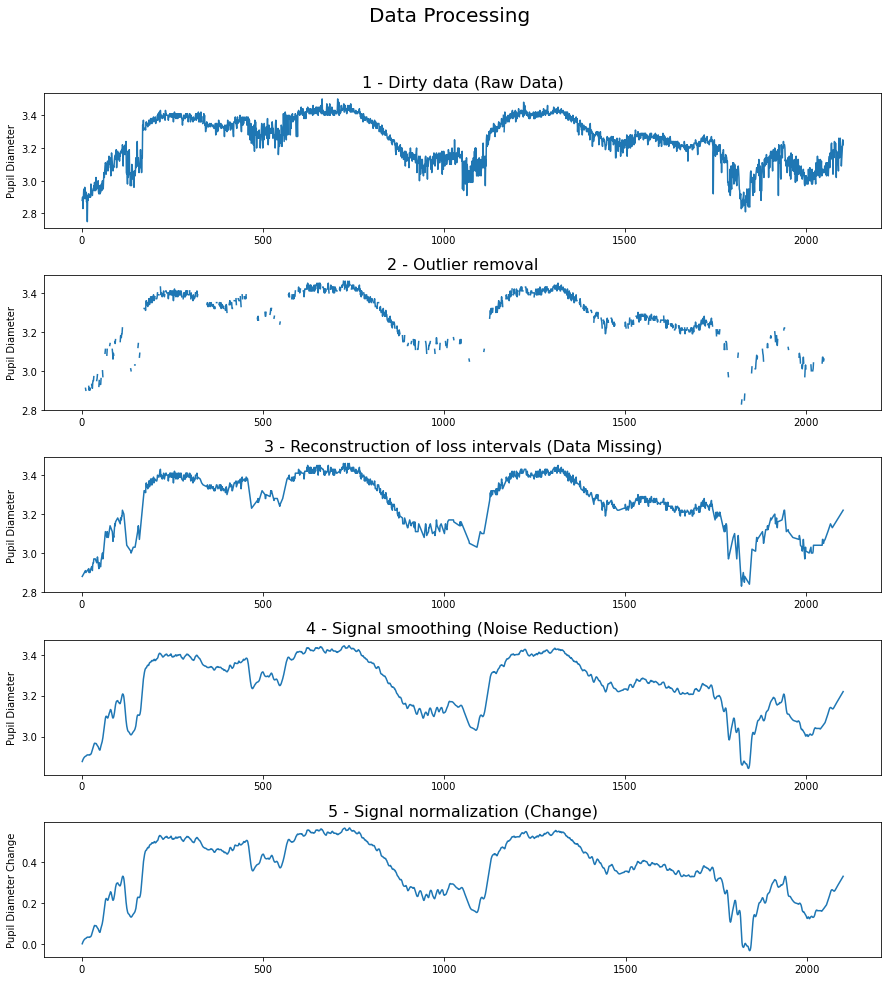

In [17]:
plt.figure(figsize = (15, 15)) # Set plot area

# Dirty Data
dftemp = df.loc[(df["ParticipantName"]==p[0])&(df["MediaName"]==stimuli[1])] # Filter participant and stimulus
x = list(range(1,len(dftemp['Pupil'])+1)) # Set the abscissa axis
y = dftemp["Pupil"] # Print untreated data
plt.subplot(5, 1, 1)
plt.plot(x,y)
plt.title("1 - Dirty data (Raw Data)", fontsize = 16)
plt.ylabel('Pupil Diameter')

# Removal of Outliers
factor = 0.04 # Define a filter factor for outliers
for i in range(0,len(dftemp)-1):
    dif = abs(dftemp.iat[i,2]-dftemp.iat[i+1,2])
    if dif > factor or math.isnan(dif):
        dftemp.iat[i,2] = np.nan
# Check if there is a difference between samples larger than the factor or if the sample is NaN (in descending order) 
for i in range(len(dftemp)-1,0,-1):
    dif = abs(dftemp.iat[i,2]-dftemp.iat[i-1,2])
    if dif > factor or math.isnan(dif):
        dftemp.iat[i,2] = np.nan
                
y = dftemp["Pupil"] # Print data without Outliers
plt.subplot(5, 1, 2)
plt.plot(x,y)
plt.title("2 - Outlier removal", fontsize = 16)
plt.ylabel('Pupil Diameter')

# Perform signal reconstruction by linear interpolation
y = dftemp.loc[:,'Pupil'].interpolate(method='linear', limit_direction='both') 
plt.subplot(5, 1, 3)
plt.plot(x,y)
plt.title("3 - Reconstruction of loss intervals (Data Missing)", fontsize = 16)
plt.ylabel('Pupil Diameter')

y = savgol_filter(y, 15, 3) # Smooth the signal to remove noise
x = list(range(1,len(y)+1))
plt.subplot(5, 1, 4)
plt.plot(x,y)
plt.title("4 - Signal smoothing (Noise Reduction)", fontsize = 16)
plt.ylabel('Pupil Diameter')

# Data after all treatment steps
y = df2.loc[(df["ParticipantName"]==p[0])&(df2["MediaName"]==stimuli[1])] # Filter participant and stimulus
x = list(range(1,len(y['Pupil'])+1)) # Set the abscissa axis
plt.subplot(5, 1, 5)
plt.plot(x,y['Pupil'])
plt.title("5 - Signal normalization (Change)", fontsize = 16)
plt.ylabel('Pupil Diameter Change')

plt.suptitle("Data Processing", fontsize = 20)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.35)
plt.show()

## Step 8 - Write processed file

In [15]:
# Save the dataset
df2.to_csv('data_pupil.csv', index=False, sep="\t") # Write file